In [ ]:
! pip install GPy gpyopt

In [ ]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from numpy.random import seed
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from numba import njit
seed(12354)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#cd drive/My Drive/SCM

In [ ]:
!git clone https://github.com/Nina-Konovalova/Bayesian-optimization.git

Cloning into 'Bayesian-optimization'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 191 (delta 79), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (191/191), 7.42 MiB | 12.04 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [ ]:
cd /content/Bayesian-optimization/Landscape

/content/Bayesian-optimization/Landscape


## experiments (real data)

In [ ]:
X_e = pd.read_csv('experimental_data.csv')
X_e = np.array(X_e)

In [ ]:
#cheb_approx = the .py file with function to approximate some distributions. Can be used for any array.
#X_e - the array, that should be parametrize. It's shape should have 2 dimensions (i,j), where i - nums of experiments and j - the array for parametrize size
# n - degree of chebyshev polynomial

from cheb_approx import chebyshev_approx

Shape of experimental data (9, 8)


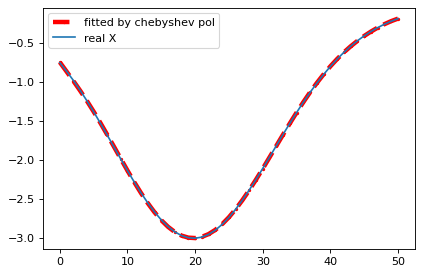

In [ ]:
n = 7
X_parametr_pol_e = chebyshev_approx(X_e,n)
print("Shape of experimental data", X_parametr_pol_e.shape)

In [ ]:
X_parametr_pol_e[8].shape

(8,)

In [ ]:
xyz = np.array([-0.5]*8)
xyz

array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5])

0.08361610000000001


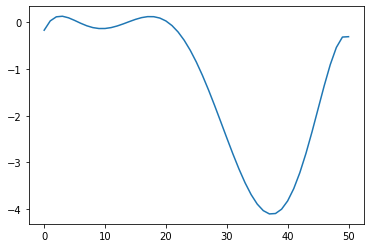

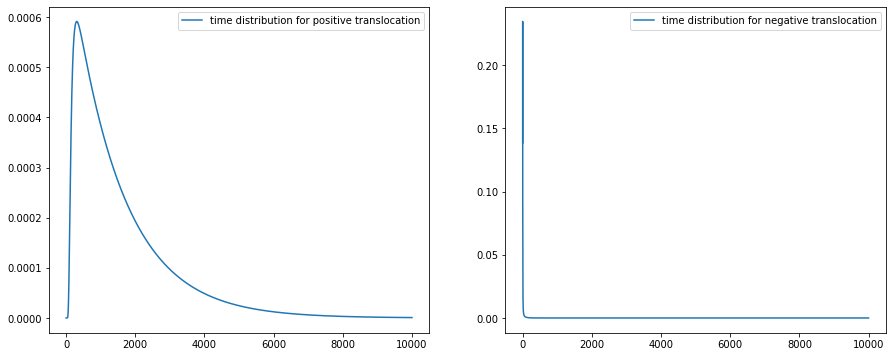

In [ ]:
#import function to find time distribution for the free enregy landscape

from probabilities_from_init_distributions import probabilities_from_init_distributions

Y_pos_real, Y_neg_real, rate_real =  probabilities_from_init_distributions (X_parametr_pol_e[1])
print(rate_real)
fig, axes = plt.subplots(1, 2)
axes[0].plot(Y_pos_real, label = 'time distribution for positive translocation')
axes[0].legend()
axes[1].plot(Y_neg_real, label = 'time distribution for negative translocation')
axes[1].legend()

fig.set_figwidth(15)    #  ширина и
fig.set_figheight(6)  

plt.show()

## Initial data

Parametrizing initial distributions (polynomial of 4 degree) - 360 initial data

### Parametrizing initial distributions (by $\textbf{Chebyshev polynomial}$ of 4 degree) - 600 initial data

In [ ]:
X1 = pd.read_csv('initial_data.csv').set_index('Unnamed: 0')
X2 = pd.read_csv('initial_data(1).csv').set_index('Unnamed: 0')
X3 = pd.read_csv('initial_data(2).csv').set_index('Unnamed: 0')
X = pd.concat((X1,X2), axis = 0)
X = pd.concat((X,X3), axis = 0)
print("Initial dataset shape", X.shape)

Initial dataset shape (360, 51)


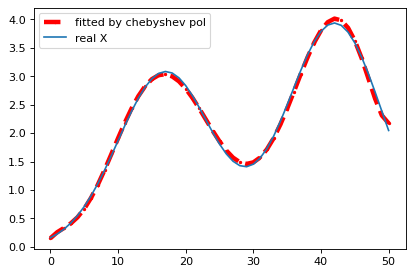

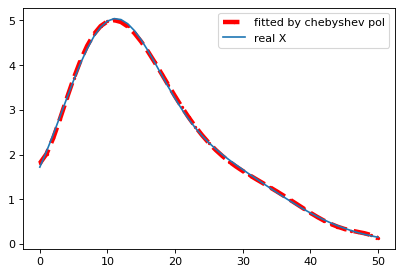

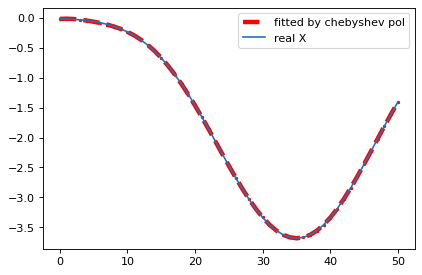

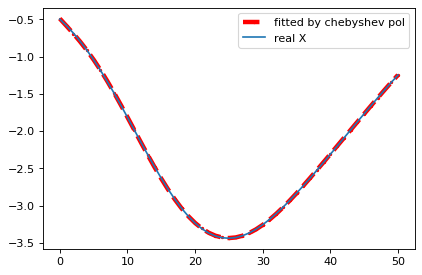

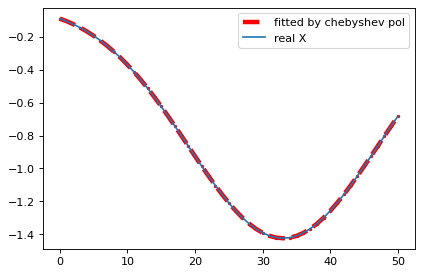

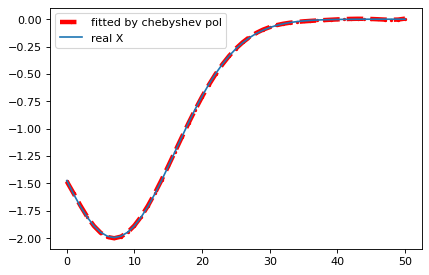

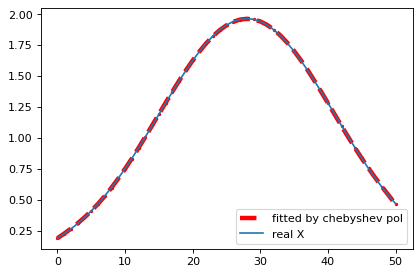

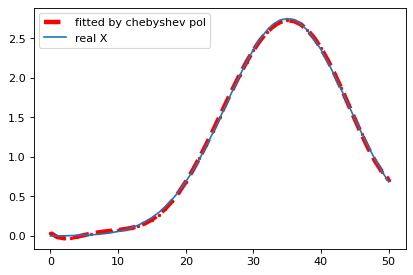

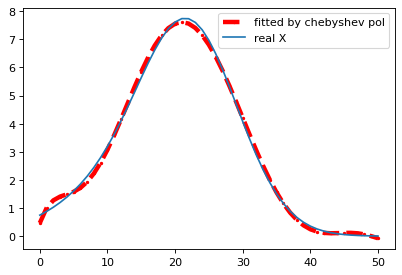

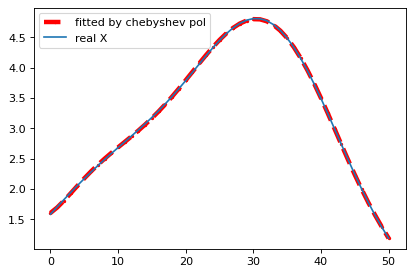

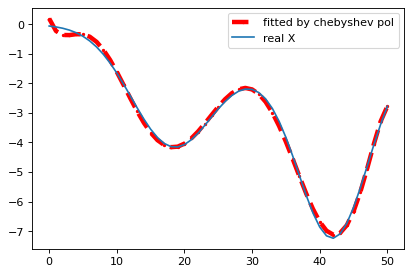

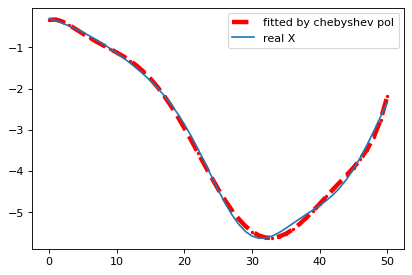

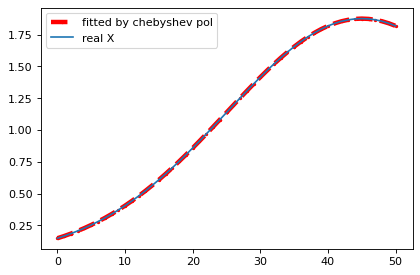

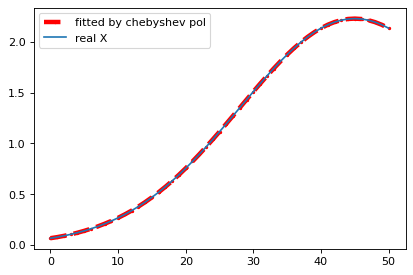

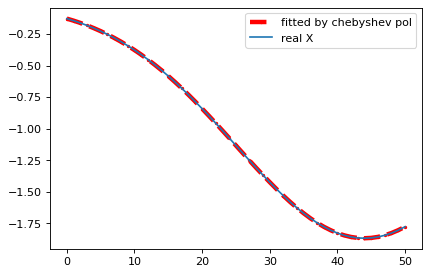

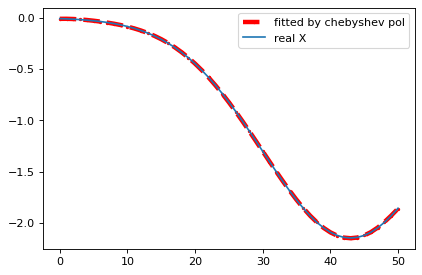

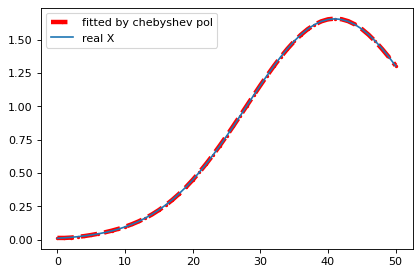

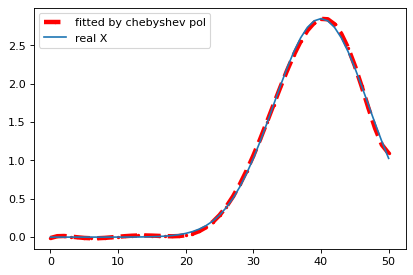

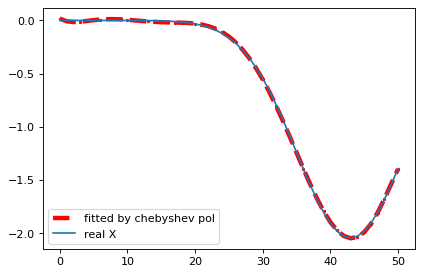

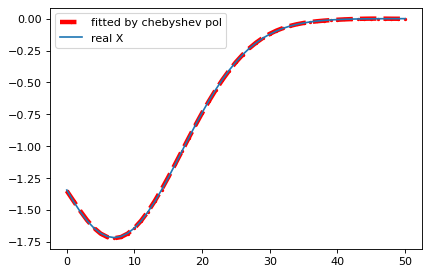

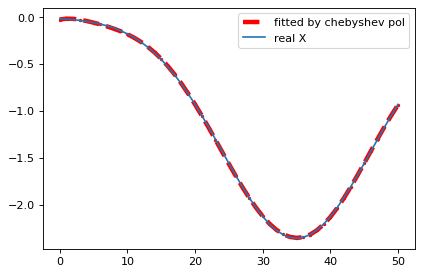

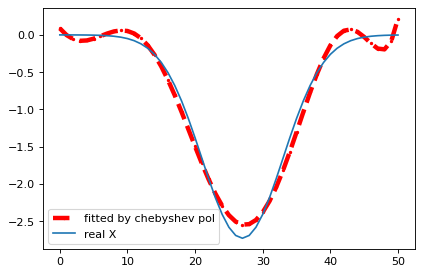

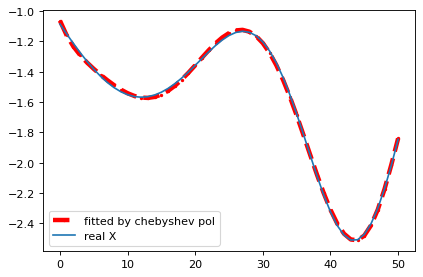

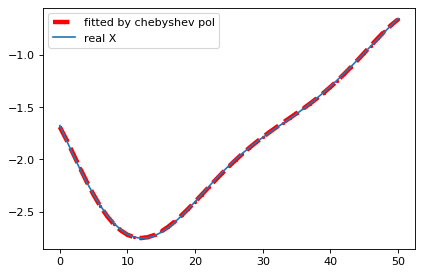

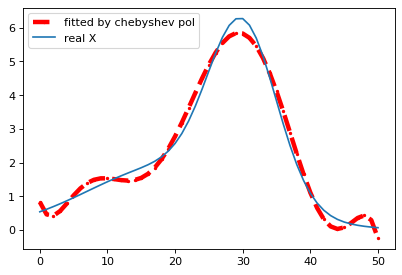

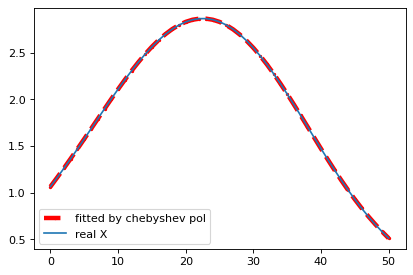

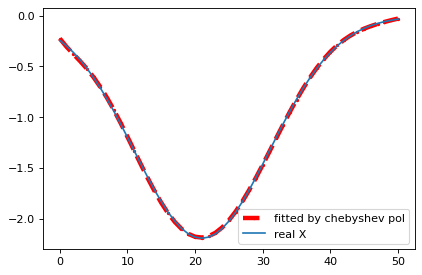

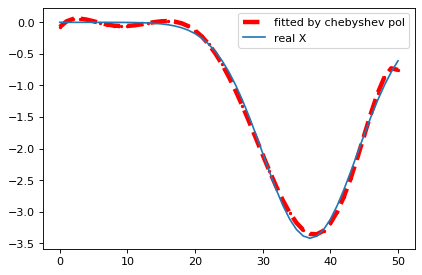

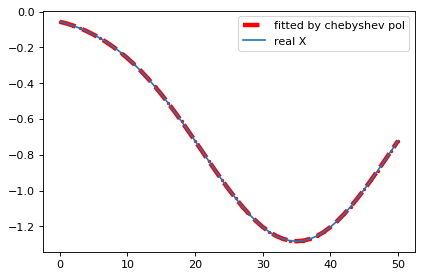

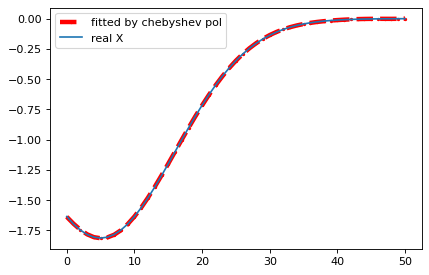

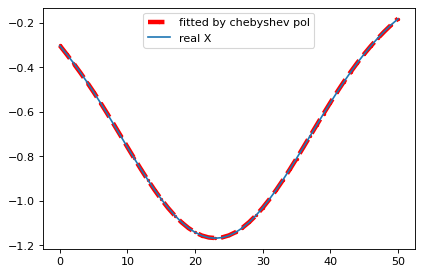

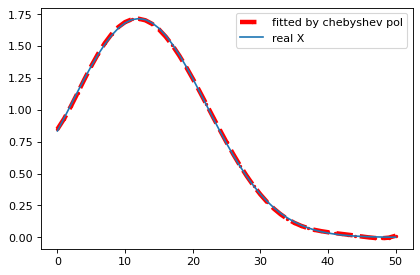

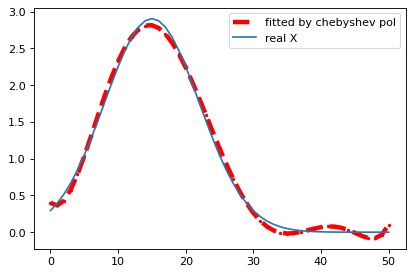

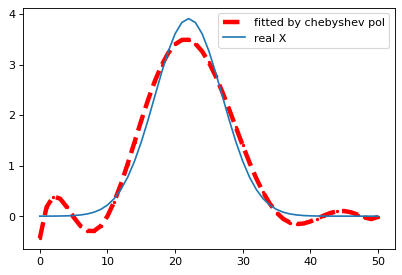

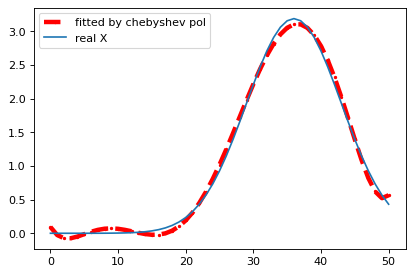

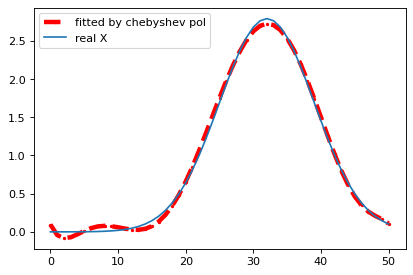

In [ ]:
import pandas as pd
import numpy.polynomial.chebyshev as cheb
import numpy as np
X = np.array(X)
X_parametr_pol = chebyshev_approx(X,n)

## Constructing function for optimization

In [ ]:
import subprocess
subprocess.call(["gfortran","-o","outputic","F.f90"]) #just for compile the programm

def Fokker_plank_eq (x_end):

    #dat2 = pd.read_csv('./try_to_estim_res1.txt', sep=' ',nrows=1, header=None)
    #rate_real = float(dat2[11])
    #saving new input data
    N = 51
    t = 1
    num1 = 50000
    f = open('./new_input.txt', 'w')
    f.write(str(N-1) + '\t'+ str(t) + '\n' + str(num1)+ '\t'+ str(t) +'\t' + str(10000)+ '\t'+ str(t) + '\n' )
    x = []
    y = []
    for i in range (N-1):
         
          f.write(str(i) + '\t' + str(real(np.polynomial.chebyshev.chebval(i,np.array(x_end)[0]))) + '\n')
    f.write (str(50) + '\t' + str(np.polynomial.chebyshev.chebval(51,np.array(x_end[0]))))
    f.close()

    plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),np.array(x_end)[0]))
    plt.show()

    #fortran programm - making new distributions
    subprocess.check_output(["./outputic"])
    #saving new output data
    dat = pd.read_csv('./new_output.txt', sep=' ',skiprows=[0,1,2], header=None)
    dat.drop(dat.columns[0], axis = 1, inplace = True)
    dat.fillna(1e+20, inplace = True)
    r = pd.read_csv('./new_output.txt', sep=' ',nrows=1, header=None)
    r.fillna(1e+20, inplace = True)
    rate = np.array(r)[0][11]
    rate=  float(rate)
    #if str(rate).find('E')==0:
    #  rate = float(str(rate).split('-')[0]) + 'E' + '-' + (str(rate).split('-')[1])

    rate = float(rate)
    print(rate)
    Y_pos_new = np.array(dat[1][:], dtype = float)
    Y_neg_new = np.array(dat[2][:], dtype = float)
        
    if rate == 1e20:
      return 1e20

    if rate < 1e-7:
      return 1e20
    

    # mse for minimization
    loss_true = mse((Y_pos_new[:]),(Y_pos_real[:]))
    loss_false = mse((Y_neg_new[:]),(Y_neg_real[:]))
    #loss_false *= 10**(-int(math.log((2*loss_false)/(loss_true),10)))
    loss_rate = abs(rate - rate_real)
    loss_rate *= 10**(-int(math.log((2*loss_rate)/(loss_true + loss_false),10)))
    #print('f',loss_rate,loss_true, loss_rate)
    diff_new = loss_false + loss_true + loss_rate
    #diff_new *= 10**(-int(math.log((diff_new)/(1),10)))
    return diff_new

## BO optimization

In [ ]:
#bounds for our function

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-1.5,1.5)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (-1,1)}, #2
        {'name': 'var_3', 'type': 'continuous', 'domain': (-1e-1,1e-1)}, #3
        {'name': 'var_4', 'type': 'continuous', 'domain': (-1e-2,1e-2)}, #5
        {'name': 'var_5', 'type': 'continuous', 'domain': (-1e-3,1e-3)},
        {'name': 'var_6', 'type': 'continuous', 'domain': (-1e-5,1e-5)},
        {'name': 'var_7', 'type': 'continuous', 'domain': (-1e-8,1e-8)},
        {'name': 'var_8', 'type': 'continuous', 'domain': (-1e-10,1e-10)}]

In [ ]:
# space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-1.5,1.5)},
#         {'name': 'var_2', 'type': 'continuous', 'domain': (-1,1)}, #2
#         {'name': 'var_3', 'type': 'continuous', 'domain': (-1,1)}, #3
#         {'name': 'var_4', 'type': 'continuous', 'domain': (-1,1)}, #5
#         {'name': 'var_5', 'type': 'continuous', 'domain': (-1,1)},
#         {'name': 'var_6', 'type': 'continuous', 'domain': (-1,1)},
#         {'name': 'var_7', 'type': 'continuous', 'domain': (-1,1)},
#         {'name': 'var_8', 'type': 'continuous', 'domain': (-1,1)}]

In [ ]:
for i in range (len(X_parametr_pol_e)):
  print(X_parametr_pol_e[i][3])

-0.00027380907909400486
0.001611840504957544
-0.004275788743500803
0.0008226686287489213
-0.0002264580492760492
0.0004696054159954286
0.007450681881058245
-3.2822547522621254e-05
0.002055544020724781


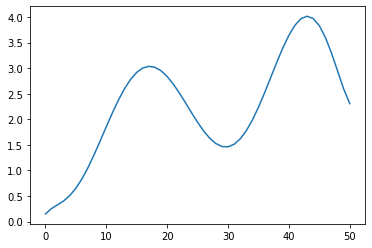

0.00288473


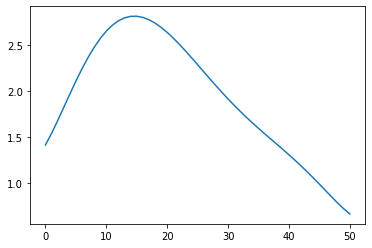

0.022628799999999998


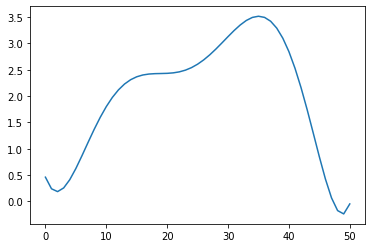

0.00618458


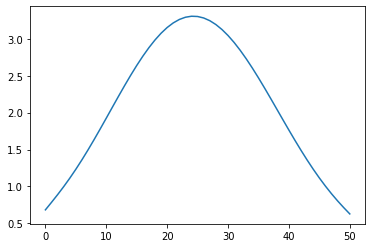

0.00721661


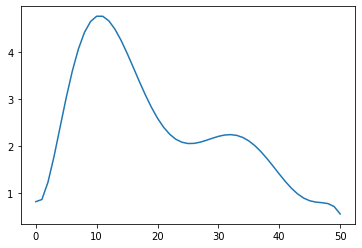

0.00339055


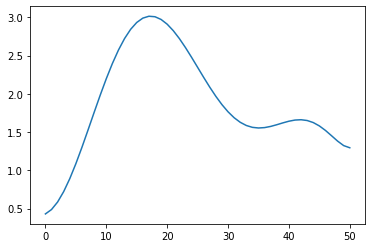

0.00817066


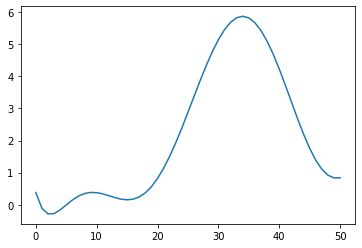

0.000521679


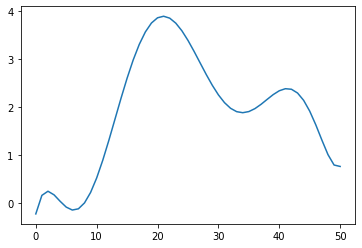

0.00475837


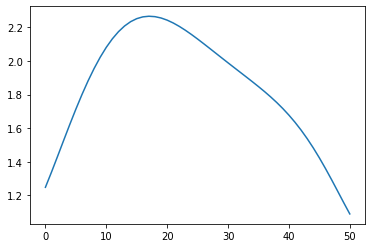

0.022328599999999997


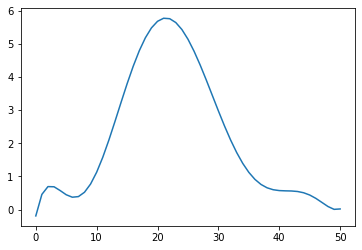

0.00165617


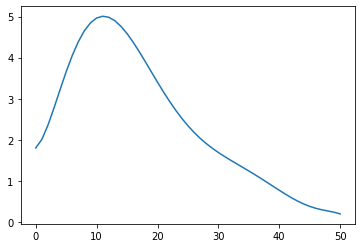

0.00966748


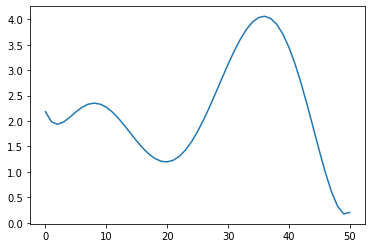

0.0213138


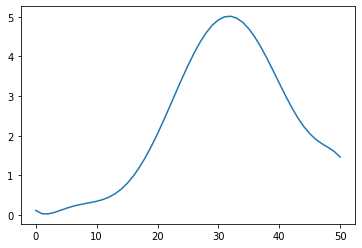

0.000975087


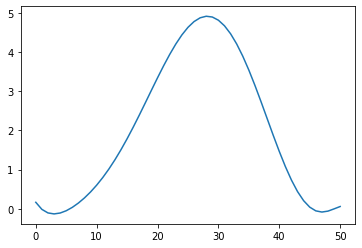

0.00126831


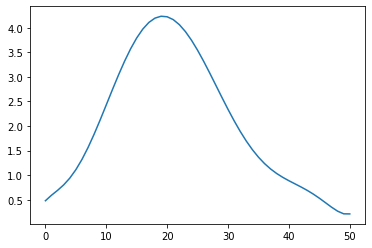

0.00437535


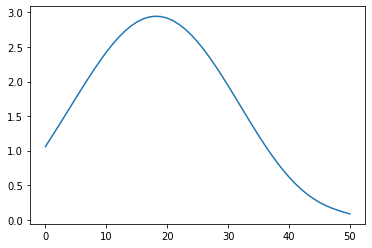

0.0170068


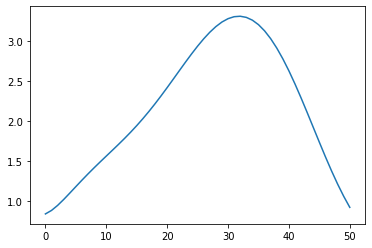

0.00743356


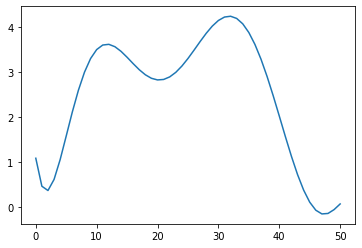

0.00268337


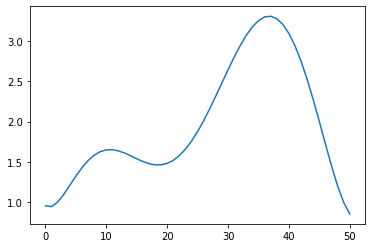

0.00983067


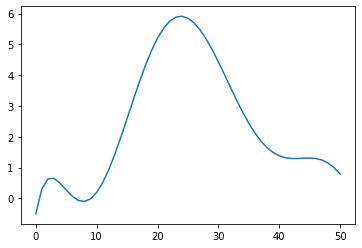

0.000960688


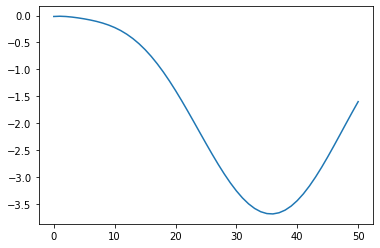

0.142333


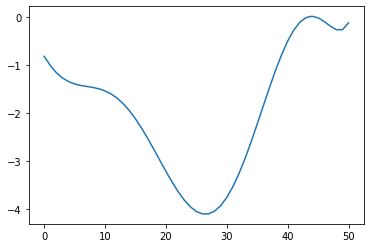

0.0591047


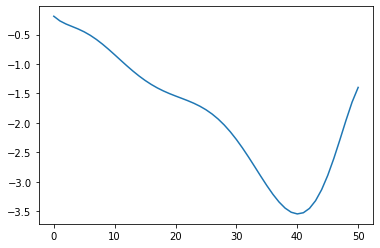

0.146567


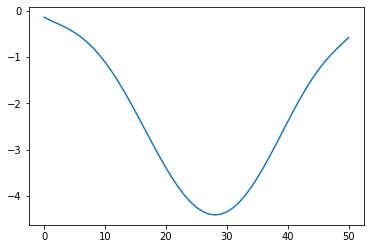

0.16359100000000001


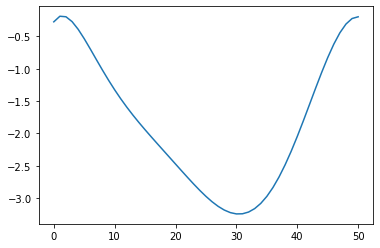

0.129144


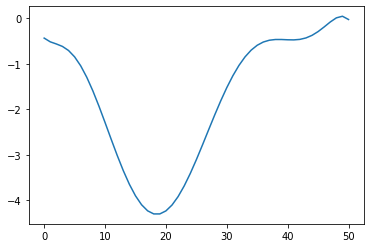

0.0575862


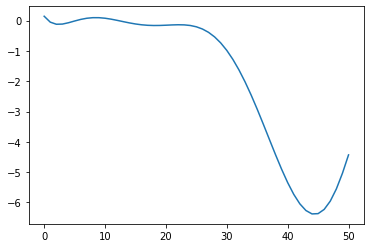

0.158309


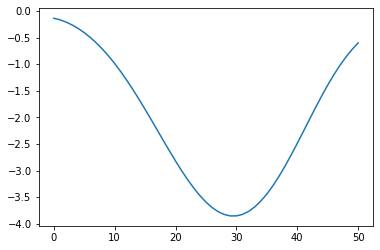

0.157891


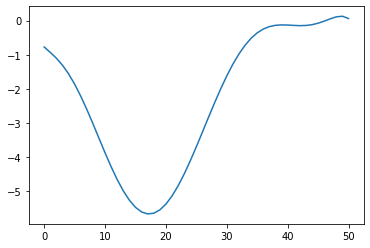

0.035580099999999996


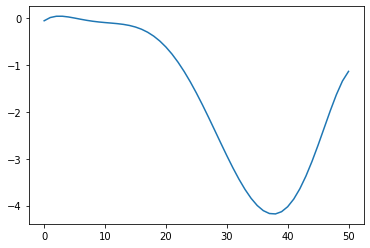

0.111516


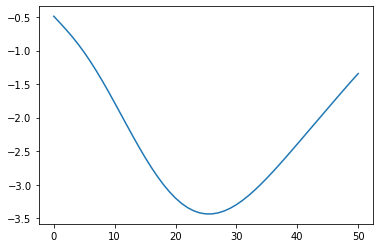

0.164633


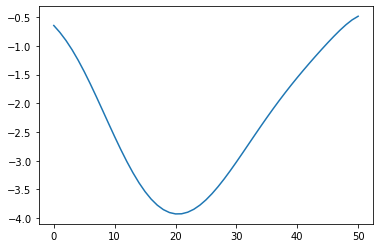

0.110766


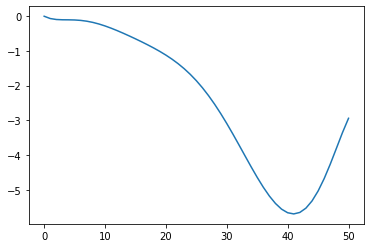

0.16936199999999998


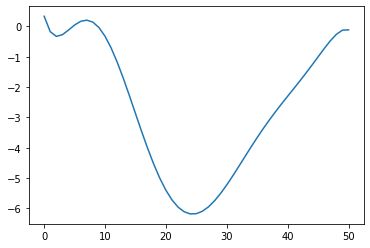

0.0872888


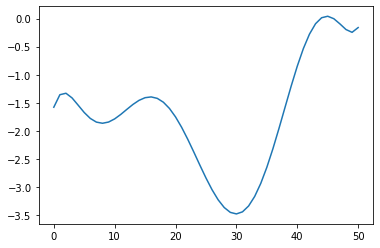

0.0460003


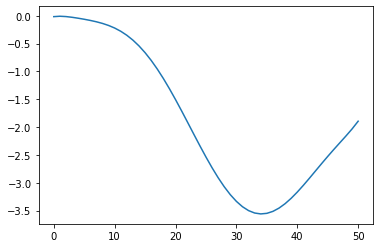

0.13861400000000001


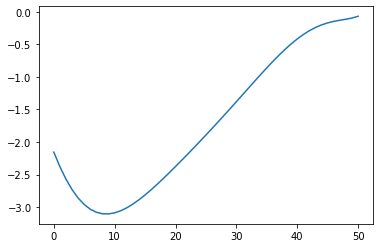

0.0113534


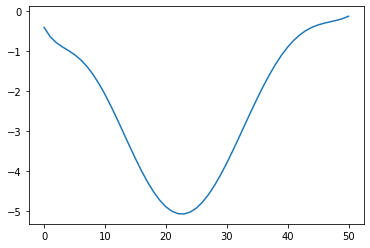

0.08553619999999999


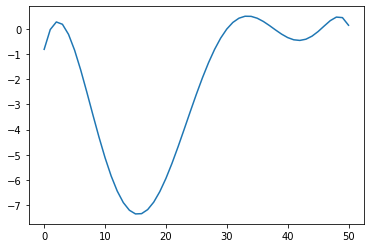

0.0563207


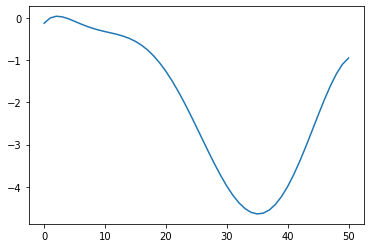

0.134357
Using a model defined by the used.
16.377164617000062


In [ ]:
seed(123456)
from time import perf_counter
# BO object
import math
kernel = GPy.kern.RBF(n+1, 1.5, 2)*GPy.kern.Matern52(input_dim = n+1) + GPy.kern.Bias(input_dim=n+1)

kernel.randomize()
model = GPyOpt.models.GPModel(optimize_restarts=1, exact_feval = True) #GP model without noize and with 3 restarts
#model.model = m
t1_start = perf_counter()  
myBopt = GPyOpt.methods.BayesianOptimization(f = Fokker_plank_eq,        # function to optimize       
                                            # model_update_interval = 3,
                                           #  evaluator_type = "local_penalization",
                                          #   batch_size = 5,
                                             domain = space,        # box-constraints of the problem
                                             #model_type='InputWarpedGP',
                                             model = model,
                                             X = X_parametr_pol[:40], 
                                             normalize_Y = True,
                                             verbosity = True,
                                             acquisition_type ='MPI') # acquisition = Expected improvement

t1_stop = perf_counter()
print(t1_stop - t1_start)                          

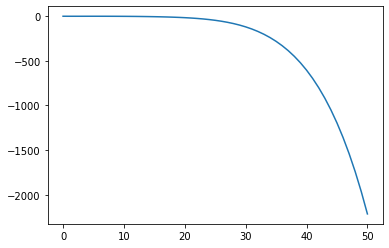

0.0008988430000000001


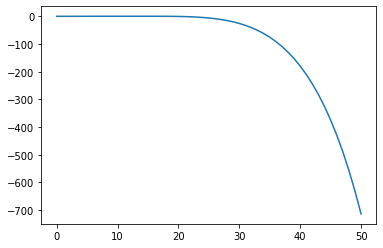

0.00101222


In [ ]:
t1_start = perf_counter()
myBopt.run_optimization(10)
t1_stop = perf_counter()
print(t1_stop - t1_start) 

### Many-many experiments

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),hills), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',hills)

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[8]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[8])

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[7]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[7])

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[6]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[6])

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[5]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[5])

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[4]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[4])

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[0]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[0])

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[1]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[1])

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[2]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[2])

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[1]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[1])

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[0]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[0])

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[3]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[3])

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[6]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()
print('Predicted params \n',myBopt.x_opt)
print('Real params \n',X_parametr_pol_e[6])

In [ ]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_pol_e[8]), color = 'g', label = 'init distribution')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), c = 'DarkBlue',label = 'results of predictions', )
plt.legend()